# Exploring the Movielens dataset with the Spark RDD API

# Prerequisites

## Installing Spark Environment
Since we are not running on databricks, we will need to install Spark by ourselves, every time we run the session.   

In [1]:
!pip install pyspark


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip


In [2]:
import matplotlib.pyplot as plt
from prettytable import PrettyTable

plt.style.use('default')
plt.rc('text', usetex=True)
plt.rc('font', family='sans-serif')
plt.rc('font', size=18)
plt.rc('axes', titlesize=12)
plt.rc('axes', labelsize=12)
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)
plt.rc('legend', fontsize=12)
plt.rc('lines', markersize=12)

In [3]:
import pyspark
from pyspark.sql import SparkSession
from pyspark import SparkContext, SparkConf

In [4]:
conf = SparkConf() \
    .setMaster('local[*]') \
    .set('spark.ui.port', '4050')

In [5]:
spark = SparkSession.builder.config(conf=conf).getOrCreate()

23/12/19 13:50:48 WARN Utils: Your hostname, Beta.local resolves to a loopback address: 127.0.0.1; using 10.113.217.51 instead (on interface en0)
23/12/19 13:50:48 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/12/19 13:50:49 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [6]:
spark

## Optional step : Enabling Spark UI through secure tunnel
This step is useful if you want to look at Spark UI.
First, you need to create a free ngrok account : https://dashboard.ngrok.com/login.  
Then connect on the website and copy your AuthToken.

In [7]:
"""# this step downloads ngrok, configures your AuthToken, then starts the tunnel
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip
#!./ngrok authtoken my_ngrok_auth_token_retrieved_from_website # <-------------- change this line !
get_ipython().system_raw('./ngrok http 4050 &')"""

"# this step downloads ngrok, configures your AuthToken, then starts the tunnel\n!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip\n!unzip ngrok-stable-linux-amd64.zip\n#!./ngrok authtoken my_ngrok_auth_token_retrieved_from_website # <-------------- change this line !\nget_ipython().system_raw('./ngrok http 4050 &')"

## Other Imports

In [8]:
%matplotlib inline

import urllib
import urllib.request as req
import zipfile
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

## Downloading the dataset

In [9]:
"""url = 'http://files.grouplens.org/datasets/movielens/ml-20m.zip'
filehandle, _ = urllib.request.urlretrieve(url)
zip_file_object = zipfile.ZipFile(filehandle, 'r')
zip_file_object.namelist()
zip_file_object.extractall()"""

"url = 'http://files.grouplens.org/datasets/movielens/ml-20m.zip'\nfilehandle, _ = urllib.request.urlretrieve(url)\nzip_file_object = zipfile.ZipFile(filehandle, 'r')\nzip_file_object.namelist()\nzip_file_object.extractall()"

In [10]:
!ls -R

Book 8.pdf                     ngrok-stable-linux-amd64.zip
MapReduce-book-final.pdf       ngrok-stable-linux-amd64.zip.1
TP1.ipynb                      ngrok-stable-linux-amd64.zip.2
TP2.ipynb                      ngrok-stable-linux-amd64.zip.3
lecture1.ipynb                 shake.txt
ml-20m                         t1-rdd-questions.ipynb
ngrok

./ml-20m:
README.txt          genome-tags.csv     movies.csv          sampled_ratings.csv
genome-scores.csv   links.csv           ratings.csv         tags.csv

./ml-20m/sampled_ratings.csv:
_SUCCESS
part-00000-bfb7f42a-5296-45a0-bc7a-cfd2a34d49a7-c000.csv
part-00001-bfb7f42a-5296-45a0-bc7a-cfd2a34d49a7-c000.csv
part-00002-bfb7f42a-5296-45a0-bc7a-cfd2a34d49a7-c000.csv
part-00003-bfb7f42a-5296-45a0-bc7a-cfd2a34d49a7-c000.csv
part-00004-bfb7f42a-5296-45a0-bc7a-cfd2a34d49a7-c000.csv
part-00005-bfb7f42a-5296-45a0-bc7a-cfd2a34d49a7-c000.csv
part-00006-bfb7f42a-5296-45a0-bc7a-cfd2a34d49a7-c000.csv
part-00007-bfb7f42a-5296-45a0-bc7a-cfd2a34d49a7-c000.c

In [11]:
movies_path = "ml-20m/movies.csv"
ratings_path = "ml-20m/ratings.csv"

## Loading the data

Loading data with Spark Dataframe API.  
Loading a csv with the RDD API is not supported out of the box and is painful to implement.

In [12]:
ratings_df = spark.read.options(header=True, inferSchema=True).csv(ratings_path)

Did you notice this created a job in the Spark UI? I thought Spark was lazy until we requested an action ?  
Rerun the same command with inferSchema=False and compare the schema with the command df.printSchema(). Can you understand why Spark triggered a job and what it was for ?

Two jobs are created when using inferSchema option. Spark needs to scan the whole dataset in order to infer the data type of each column. Yet, if you disable this option, you will realize that there is still one short job created. So much for the laziness ! To generate the dataframe, Spark needs to know how many columns we have inside each row. That's why a first job is created. Let's keep the inferSchema option set to True for now.

In [13]:
ratings_df.take(1)

[Row(userId=1, movieId=2, rating=3.5, timestamp=1112486027)]

In [14]:
ratings_rdd = ratings_df.rdd.map(lambda x: x.asDict())

In [15]:
ratings_rdd.take(3)

[{'userId': 1, 'movieId': 2, 'rating': 3.5, 'timestamp': 1112486027},
 {'userId': 1, 'movieId': 29, 'rating': 3.5, 'timestamp': 1112484676},
 {'userId': 1, 'movieId': 32, 'rating': 3.5, 'timestamp': 1112484819}]

Record type of a dataframe is the 'Row'. You can have any record type inside your RDD, we are using Python dictionaries there.

In [16]:
movies_df = spark.read.options(header=True, inferSchema=True).csv(movies_path)
movies_rdd = movies_df.rdd.map(lambda x: x.asDict())

In [17]:
movies_rdd.take(1)

[{'movieId': 1,
  'title': 'Toy Story (1995)',
  'genres': 'Adventure|Animation|Children|Comedy|Fantasy'}]

The ratings RDD is a bit large (about 2 min to run a request on it on a container with two cores). You can work on a smaller version of it to develop and debug your job and then run it on the full RDD to get the result.  
Why do we persist the small RDD and not the regular one ?

In [18]:
ratings_small_rdd = ratings_rdd.filter(lambda x: x['userId'] < 20000).persist(pyspark.StorageLevel.DISK_ONLY)

If we persist the non-filtered RDD, we will lose all the benefits of the persist function and we will need to read the whole dataset every time. Some other remarks: when doing real analysis, filtering on userId may yield biased results, because you are likely to work with oldest users subscribed to MovieLens ; persist-to-disk function benefits are lost if you stop your Spark session. If your analysis is spanning over multiple sessions, you should save your dataset to distributed file system ; persist-to-memory may be adapted if you are running an iterative algorithm, but be vary, when using persist-to-memory, memory of executors may be shared with other users and you don't have a full guarantee that some partitions won't be recomputed from scratch at some point.

Here we will sample dataset and save it to DFS, then read-it again.

In [19]:
sampled_path = "ml-20m/sampled_ratings.csv"
ratings_df.sample(fraction=0.1).write.format("csv").save(sampled_path, mode="overwrite", header=True)

In [20]:
ratings_small_df = spark.read.options(header=True, inferSchema=True).csv(sampled_path)
ratings_small_rdd = ratings_small_df.rdd.map(lambda x: x.asDict())

Use the sampled rdd when tinkering with your RDD. When you are sure about what you are doing, you can try to use the entire RDD.

# Questions

### Q1. How many ratings ?

In [21]:
print("Number of ratings : {}".format(ratings_small_rdd.count()))

Number of ratings : 1999542


### Q2. How many users ?

Read the documentation for the distinct function in the RDD API and find a solution with this method.
There is another solution relying on a more generic function ? Can you solve the problem without using distinct function ?

In [22]:
print("Number of users : {}".format(ratings_small_rdd.map(lambda x: x['userId']).distinct().count()))

Number of users : 135714


### Q3. How many ratings per grade ?

How many users rated a movie with grade r for r in [0,5]?    
Plot it. Do you notice something unusual ?

[(0.5, 24144), (1.0, 67809), (1.5, 27886), (2.0, 143078), (2.5, 88415), (3.0, 429180), (3.5, 220338), (4.0, 555991), (4.5, 153256), (5.0, 289445)]


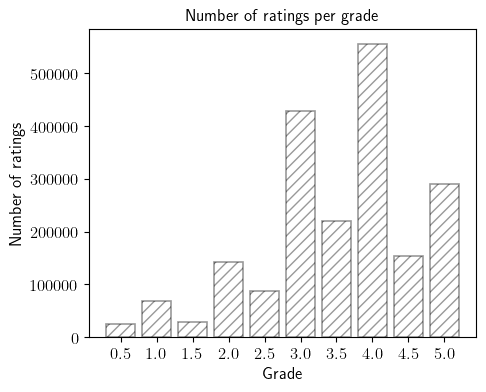

In [23]:
ratings_per_grade = ratings_small_rdd.map(lambda x: (x['rating'], 1)).reduceByKey(lambda x, y: x + y).collect()
print(ratings_per_grade)

fig, ax = plt.subplots(figsize=(5, 4))
ax.bar([x[0] for x in ratings_per_grade], [x[1] for x in ratings_per_grade], width=0.4, align='center',
       edgecolor='black', linewidth=1.2, facecolor='white', hatch='///', alpha=0.4)
ax.set_xlabel('Grade')
ax.set_xticks([x[0] for x in ratings_per_grade])
ax.set_ylabel('Number of ratings')
ax.set_title('Number of ratings per grade')
plt.show()

### Q4. Histogram of number of ratings per user

Plot the distribution of the number of movies rated per user. In other words, what is the fraction of users that rated between bins[i] and bins[i+1] movies for the following bins.  
What is the average and median number of ratings per user?

In [24]:
bins = np.unique(np.logspace(0, 160, base=1.05, num=50, dtype='int32'))
bins

array([   1,    2,    3,    4,    5,    6,    7,    9,   10,   12,   15,
         17,   20,   24,   28,   33,   39,   45,   53,   62,   73,   86,
        101,  119,  139,  163,  191,  225,  264,  309,  363,  425,  499,
        585,  686,  805,  944, 1107, 1298, 1523, 1786, 2094, 2456],
      dtype=int32)

In [25]:
ratings_per_user = ratings_small_rdd.map(lambda x: (x['userId'], 1)).reduceByKey(lambda x, y: x + y).collect()
ratings_per_user = np.array([x[1] for x in ratings_per_user])

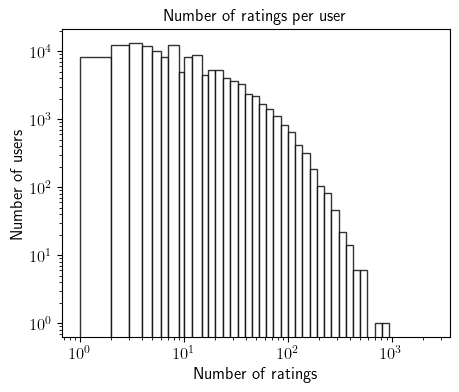

In [26]:
fig, ax = plt.subplots(figsize=(5, 4))
ax.hist(ratings_per_user, bins=bins, edgecolor='black', facecolor='white', alpha=0.8)
ax.set_xlabel('Number of ratings')
ax.set_ylabel('Number of users')
ax.set_title('Number of ratings per user')
ax.set_xscale('log')
ax.set_yscale('log')
plt.show()

### Q5. Most popular movies

What are the 20 movies with the most ratings ?  
We would like the answer with the movie title and not the movie id.  
Look at the documentation of the join and top functions.

In [27]:
tables = PrettyTable(['Movie', 'Number of ratings'])
for movie in ratings_small_rdd.map(lambda x: (x['movieId'], 1)).reduceByKey(lambda x, y: x + y).join(
        movies_rdd.map(lambda x: (x['movieId'], x['title']))).top(20, key=lambda x: x[1][0]):
    tables.add_row([movie[1][1], movie[1][0]])
print(tables)

+-------------------------------------------------------+-------------------+
|                         Movie                         | Number of ratings |
+-------------------------------------------------------+-------------------+
|                  Pulp Fiction (1994)                  |        6812       |
|                  Forrest Gump (1994)                  |        6602       |
|            Shawshank Redemption, The (1994)           |        6353       |
|            Silence of the Lambs, The (1991)           |        6259       |
|                  Jurassic Park (1993)                 |        6003       |
|                   Braveheart (1995)                   |        5411       |
|       Star Wars: Episode IV - A New Hope (1977)       |        5392       |
|                   Matrix, The (1999)                  |        5195       |
|           Terminator 2: Judgment Day (1991)           |        5193       |
|                Schindler's List (1993)                |       

### Q6. Writing partioned datasets

The ratings dataset is available as one big csv file. It is not very convenient since we have to go through the entire file to look for ratings for a specific userId. Moreover, we cannot open only a small part of the dataset.  
Could you write the ratings dataset into 16 files located in /<wbr>tmp/ratings/part=X/ratings.csv for X in [0, 16[ where userId in part=X are such that userId % 16 == X ?  Your function should return the list of written files with the number of ratings for each file.
Look at the documentation of partitionBy and mapPartitionsWithIndex.

In [30]:
!ls -R /tmp/ratings

ls: /tmp/ratings: No such file or directory


In [31]:
# Display Rdd
ratings_rdd.take(1)

[{'userId': 1, 'movieId': 2, 'rating': 3.5, 'timestamp': 1112486027}]

### Q7. Most popular genre per year

For every year since 1980, determine what is the most popular genre.  
Look at the documentation of the flatMap function.

### Q8.  Best movies

Amongst the movies with at least 1000 ratings, what are the top 20 movies per median rating ?

In [32]:
def median(values):
    sorted_values = sorted(values)
    if len(sorted_values) % 2 == 1:
        return sorted_values[len(sorted_values) // 2]
    else:
        return (sorted_values[len(sorted_values) // 2 - 1] + sorted_values[len(sorted_values) // 2]) / 2


ratings_per_movie = ratings_small_rdd.map(lambda x: (x['movieId'], x['rating'])).groupByKey().mapValues(median).filter(
    lambda x: x[1] is not None).collect()
ratings_per_movie = dict(ratings_per_movie)

movies_rdd.map(lambda x: (x['movieId'], x['title'], x['genres'])).filter(
    lambda x: x[0] in ratings_per_movie and ratings_per_movie[x[0]] >= 3.5).top(20,
                                                                                key=lambda x: ratings_per_movie[x[0]])
tables = PrettyTable(['Movie', 'Median rating'])
for movie in movies_rdd.map(lambda x: (x['movieId'], x['title'], x['genres'])).filter(
        lambda x: x[0] in ratings_per_movie and ratings_per_movie[x[0]] >= 3.5).top(20,
                                                                                    key=lambda x: ratings_per_movie[
                                                                                        x[0]]):
    tables.add_row([movie[1], ratings_per_movie[movie[0]]])
print(tables)

+---------------------------------------------------------------------+---------------+
|                                Movie                                | Median rating |
+---------------------------------------------------------------------+---------------+
|               New York Cop (Nyû Yôku no koppu) (1993)               |      5.0      |
|              Wooden Man's Bride, The (Yan shen) (1994)              |      5.0      |
|              Crows and Sparrows (Wuya yu maque) (1949)              |      5.0      |
|                        Godfather, The (1972)                        |      5.0      |
| Three Lives and Only One Death (Trois vies & une seule mort) (1996) |      5.0      |
|                        Farmer & Chase (1997)                        |      5.0      |
|                      Somebody is Waiting (1996)                     |      5.0      |
|                           Cloudland (1998)                          |      5.0      |
|                              N

In [ ]:
# When you're done with a session you've created, stop it
# spark.stop()